# Image Captioning Bot

###  Steps :
- Data Collection
- Understanding The Data
- Data Cleaning
- Loading the Training Set
- Image Preprocessing
- Caption Preprocessing
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

In [25]:
import re
import cv2
import nltk
import json
import keras
import pickle
import string
import numpy as np
import pandas as pd
import collections
from time import time
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.layers.merge import add
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

In [26]:
# Read Text Captions
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [27]:
captions = readTextFile('./Data/Flickr_TextData/Flickr8k.token.txt')
captions = captions.split('\n')[:-1]
print(len(captions))
print(captions[0])

40460
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [28]:
# Dictionary to map each Image with its List of Caption
description = {}
for ix in captions:
    img,cap = ix.split('\t')
    img = img.split('.')[0]
    if description.get(img) is None:
        description[img] = []
    description[img].append(cap)

In [29]:
description['1002674143_1b742ab4b8']

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

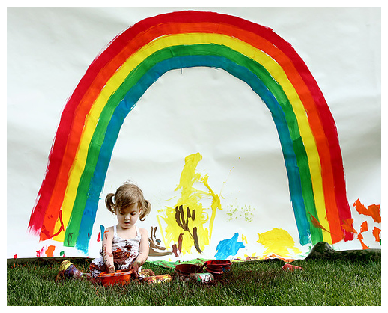

In [30]:
plt.style.use('seaborn')
IMG_PATH = 'Data/Images/'
img = cv2.imread(IMG_PATH+'1002674143_1b742ab4b8.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)
plt.show()

### Data Cleaning

In [31]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ',sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    sentence = ' '.join(sentence)
    return sentence

In [32]:
# Cleaning all captions
for img,cap_list in description.items():
    for i in range(len(cap_list)):
        cap_list[i] = clean_text(cap_list[i])

In [33]:
description['1002674143_1b742ab4b8']

['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
 'little girl is sitting in front of large painted rainbow',
 'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
 'there is girl with pigtails sitting in front of rainbow painting',
 'young girl with pigtails painting outside in the grass']

In [34]:
# Save the cleaned data in file
with open('descriptions_1.txt','w') as f:
    f.write(str(description))

### Vocabulary

In [35]:
descriptions = None
with open('descriptions_1.txt','r') as f:
    descriptions = f.read()
descriptions = json.loads(descriptions.replace("'","\""))
print(type(descriptions))

<class 'dict'>


In [36]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print('Vocabulary size : {}'.format(len(vocab)))

Vocabulary size : 8424


In [37]:
# Total no of words across all sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(word) for sent in descriptions[key] for word in sent.split()]
print('Total no of words : {}'.format(len(total_words)))

Total no of words : 373837


In [38]:
# Find the count of each word
counter = collections.Counter(total_words)
freq_count = dict(counter)
print(len(freq_count.keys()))

8424


In [67]:
# Filter words from vocab acc to certain threshold frequency
sorted_freq_count = sorted(freq_count.items(),reverse=True,key=lambda x:x[1])
threshold = 10
sorted_freq_count = [x for x in sorted_freq_count if x[1]>threshold]
total_unique_words = [x[0] for x in sorted_freq_count]
print(len(total_unique_words))

1845


### Preparing Train & Test Data

In [40]:
train_data = readTextFile('Data/Flickr_TextData/Flickr_8k.trainImages.txt')
test_data = readTextFile('Data/Flickr_TextData/Flickr_8k.testImages.txt')

In [61]:
train = [data.split('.')[0] for data in train_data.split('\n')[:-1]]
test = [data.split('.')[0] for data in test_data.split('\n')[:-1]]

In [42]:
test[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [43]:
# Add <s> and <e> to our the data
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        train_descriptions[img_id].append('startseq '+cap+' endseq')

In [44]:
train_descriptions['1002674143_1b742ab4b8']

['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq',
 'startseq there is girl with pigtails sitting in front of rainbow painting endseq',
 'startseq young girl with pigtails painting outside in the grass endseq']

###  Image Feature Extraction (Transfer Learning)

In [45]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

bn4b_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_75 (Activation)      (None, 14, 14, 256)  0           bn4b_branch2a[0][0]              
__________________________________________________________________________________________________
res4b_branch2b (Conv2D)         (None, 14, 14, 256)  590080      activation_75[0][0]              
__________________________________________________________________________________________________
bn4b_branch2b (BatchNormalizati (None, 14, 14, 256)  1024        res4b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 14, 14, 256)  0           bn4b_branch2b[0][0]              
__________________________________________________________________________________________________
res4b_bran

add_32 (Add)                    (None, 7, 7, 2048)   0           bn5c_branch2c[0][0]              
                                                                 activation_95[0][0]              
__________________________________________________________________________________________________
activation_98 (Activation)      (None, 7, 7, 2048)   0           add_32[0][0]                     
__________________________________________________________________________________________________
avg_pool (GlobalAveragePooling2 (None, 2048)         0           activation_98[0][0]              
__________________________________________________________________________________________________
fc1000 (Dense)                  (None, 1000)         2049000     avg_pool[0][0]                   
Total params: 25,636,712
Trainable params: 25,583,592
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [46]:
new_model = Model(model.input,model.layers[-2].output)

In [47]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    return img

def encode_image(img):
    img = preprocess_img(img)
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [48]:
# Encoding Training Images
start = time()
encoding_train = {}
for ix,img_id in enumerate(train):
    img_path = IMG_PATH+img_id+'.jpg'
    encoding_train[img_id] = encode_image(img_path)
    if ix%100 == 0:
        print('Train Encoding in Progress, Time Step : %d'%ix)
end = time()
print('Total Time Taken : ',end-start)

Train Encoding in Progress, Time Step : 0
Train Encoding in Progress, Time Step : 100
Train Encoding in Progress, Time Step : 200
Train Encoding in Progress, Time Step : 300
Train Encoding in Progress, Time Step : 400
Train Encoding in Progress, Time Step : 500
Train Encoding in Progress, Time Step : 600
Train Encoding in Progress, Time Step : 700
Train Encoding in Progress, Time Step : 800
Train Encoding in Progress, Time Step : 900
Train Encoding in Progress, Time Step : 1000
Train Encoding in Progress, Time Step : 1100
Train Encoding in Progress, Time Step : 1200
Train Encoding in Progress, Time Step : 1300
Train Encoding in Progress, Time Step : 1400
Train Encoding in Progress, Time Step : 1500
Train Encoding in Progress, Time Step : 1600
Train Encoding in Progress, Time Step : 1700
Train Encoding in Progress, Time Step : 1800
Train Encoding in Progress, Time Step : 1900
Train Encoding in Progress, Time Step : 2000
Train Encoding in Progress, Time Step : 2100
Train Encoding in Prog

In [56]:
# Store encoded features of training images on disk
with open('encoded_train_features.pkl','wb') as f:
    pickle.dump(encoding_train,f)

In [62]:
# Encoding Test Images
start = time()
encoding_test = {}
for ix,img_id in enumerate(test):
    img_path = IMG_PATH+img_id+'.jpg'
    encoding_test[img_id] = encode_image(img_path)
    if ix%100 == 0:
        print('Test Encoding in Progress, Time Step : %d'%ix)
end = time()
print('Total Time Taken : ',end-start)

Test Encoding in Progress, Time Step : 0
Test Encoding in Progress, Time Step : 100
Test Encoding in Progress, Time Step : 200
Test Encoding in Progress, Time Step : 300
Test Encoding in Progress, Time Step : 400
Test Encoding in Progress, Time Step : 500
Test Encoding in Progress, Time Step : 600
Test Encoding in Progress, Time Step : 700
Test Encoding in Progress, Time Step : 800
Test Encoding in Progress, Time Step : 900
Total Time Taken :  247.48157739639282


In [63]:
# Store encoded features of training images on disk
with open('encoded_test_features.pkl','wb') as f:
    pickle.dump(encoding_test,f)

### Preprocessing Captions

In [68]:
# Vocab Size
len(total_unique_words)

1845

In [73]:
word2idx = {}
idx2word = {}
for i,word in enumerate(total_unique_words):
    word2idx[word] = i+1
    idx2word[i+1] = word

word2idx['startseq'] = 1846
idx2word[1846] = 'startseq'
word2idx['endseq'] = 1847
idx2word[1847] = 'endseq'
print('Vocab Size : %d'%(len(idx2word)+1))

Vocab Size : 1848


In [74]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
print('Maximum Length of Caption : %d'%max_len)

Maximum Length of Caption : 35
